<img src='https://www.usc.gal/gl/info_xeral/imaxeusc/imaxes/001.gif'>

# Deep Learning
## Convolutional Neural Networks
### Gender prediction

**Students**
- Victor Barreiro Dominguez
- Maximiliano Hormazábal Lagos 

In [1]:
## Code made for using the GPU

import tensorflow as tf
import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

# Obtain the list of available devices
devices = tf.config.list_physical_devices('GPU')

if len(devices) > 0:
  # Set TensorFlow to use GPU
  tf.config.set_visible_devices(devices[0], 'GPU')
  print('GPU n°:', devices[0])
else:
  print('No GPU available.')

print("Current Device:", tf.test.gpu_device_name())

GPU n°: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Current Device: /device:GPU:0


# Loading data

In [2]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [3]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  1


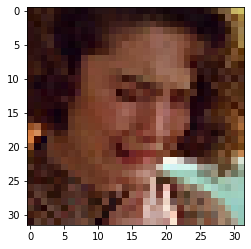

Image shape:  (32, 32, 3)
Label:  0


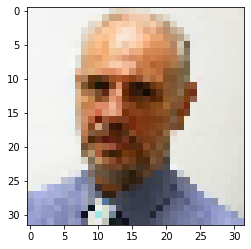

Image shape:  (32, 32, 3)
Label:  0


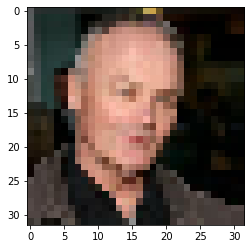

Image shape:  (32, 32, 3)
Label:  0


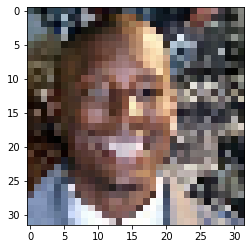

Image shape:  (32, 32, 3)
Label:  1


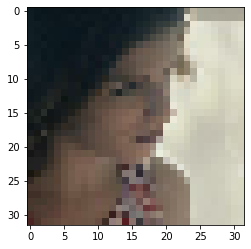

In [5]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

## Data Transformation

In [6]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: sample gender weights
# import numpy as np
# labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
# freqs = np.array([1. - np.mean(labels), np.mean(labels)])
# i_freqs = 1. / freqs
# sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
# print(sample_weights)
# ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
# ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


# Funciones auxiliares

In [7]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

dir = "models/"

def visualize_fit(history):
    """Procedure to print de evolution of a training process.

    Args:
        history (dict): _description_
    """    
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.8, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def fitModel(model, ds_train, ds_val, num_epochs=20, monitor='val_accuracy', model_name='best_model.h5', callbacks=[]):
    checkpoint = ModelCheckpoint(dir+model_name, save_best_only=True, save_weights_only=False, monitor=monitor, mode='auto', verbose=1)
    history = model.fit(ds_train, verbose = 1, epochs=num_epochs, callbacks=callbacks+[checkpoint], validation_data=ds_val)
    result = model.evaluate(ds_val)
    print(result)
    visualize_fit(history)
    return result

# Results summary

| Name         | Convolutions    | Amouny Pooling layer | Amount of parameters | Fully conected | Amount Batch N.| Epochs | Loss    | Accuracy |
|:-------------|:----------------| :-------------------:| :-------------------:| --------------:| :-------------:| :-----:| :------:| :-------:|
| test_model   | [64,128]        | 1                    | 211,905              | No             | 2              | 30     | 0.3558  | 0.8680   |
| short_model  | [64,128]        | 2                    | 6,689                | [8]            | 3              | 70     | 0.3725  | 0.8679   |
| medium_model | [32,64,256]     | 2                    | 241,897              | [8]            | 3              | 70     | 0.3361  | 0.8799   |
| big_model    | [256,512,2048]  | 2                    | 11,814,673           | [16]           | 3              | 30     | 0.3195  | 0.8740   |

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1728      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 10, 10, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 128)         204800    
                                                                 
 batch_normalization_7 (Batc  (None, 6, 6, 128)        512 

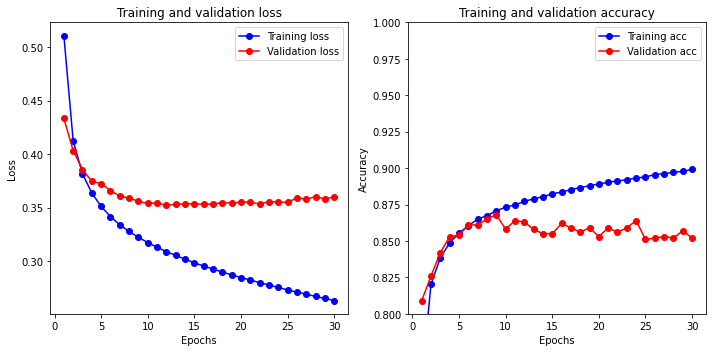

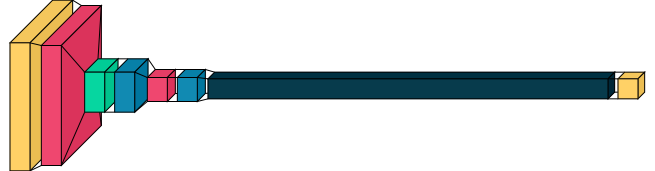

In [11]:
# test_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu', use_bias=False)(x)

x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Flatten(name = 'Flatten_Layer')(x)

output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=30, model_name="test_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [12]:
loaded_model = tf.keras.models.load_model(dir + "test_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 20ms/step - loss: 0.3559 - accuracy: 0.8680


[0.3558659255504608, 0.8680000305175781]

# Models

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 8)         216       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0     

2023-03-15 14:59:48.473141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-15 14:59:48.840723: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 14:59:49.152321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-15 14:59:49.153690: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9e240674b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 14:59:49.153700: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-03-15 14:59:49.156106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-15 14:59:49.18991

990/992 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.7936
Epoch 1: val_accuracy improved from -inf to 0.83500, saving model to models/short_model.h5
992/992 [==============================] - 5s 3ms/step - loss: 0.4485 - accuracy: 0.7936 - val_loss: 0.3927 - val_accuracy: 0.8350
Epoch 2/70
991/992 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8478
Epoch 2: val_accuracy improved from 0.83500 to 0.85000, saving model to models/short_model.h5
992/992 [==============================] - 3s 3ms/step - loss: 0.3615 - accuracy: 0.8478 - val_loss: 0.3662 - val_accuracy: 0.8500
Epoch 3/70
990/992 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8613
Epoch 3: val_accuracy improved from 0.85000 to 0.85300, saving model to models/short_model.h5
992/992 [==============================] - 3s 3ms/step - loss: 0.3378 - accuracy: 0.8613 - val_loss: 0.3726 - val_accuracy: 0.8530
Epoch 4/70
978/992 [============================>.]

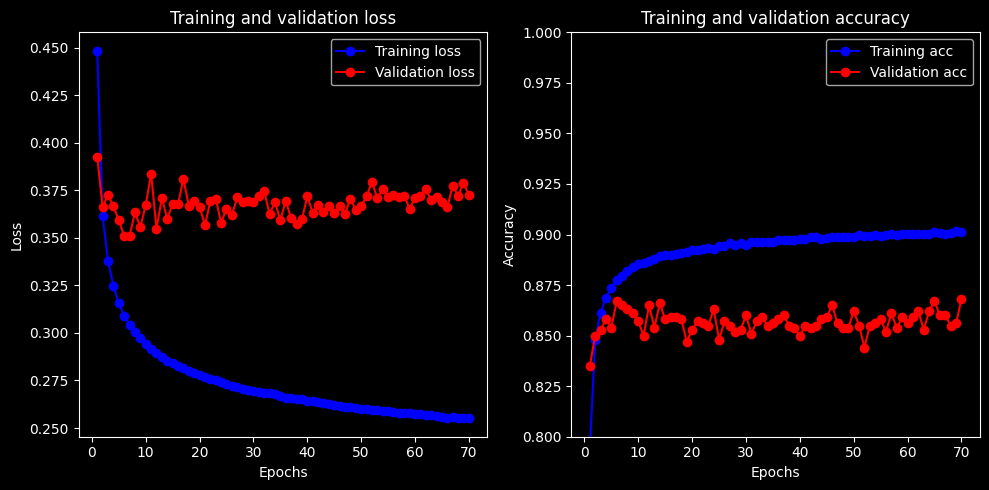

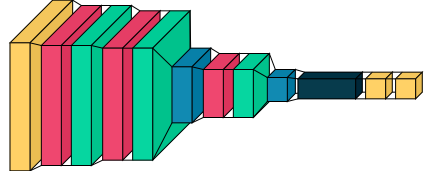

In [12]:
# short_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(8, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)

x = Dense(8, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=70, model_name="short_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [13]:
loaded_model = tf.keras.models.load_model(dir + "short_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 3ms/step - loss: 0.3726 - accuracy: 0.8680


[0.3725680112838745, 0.8679999709129333]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0   

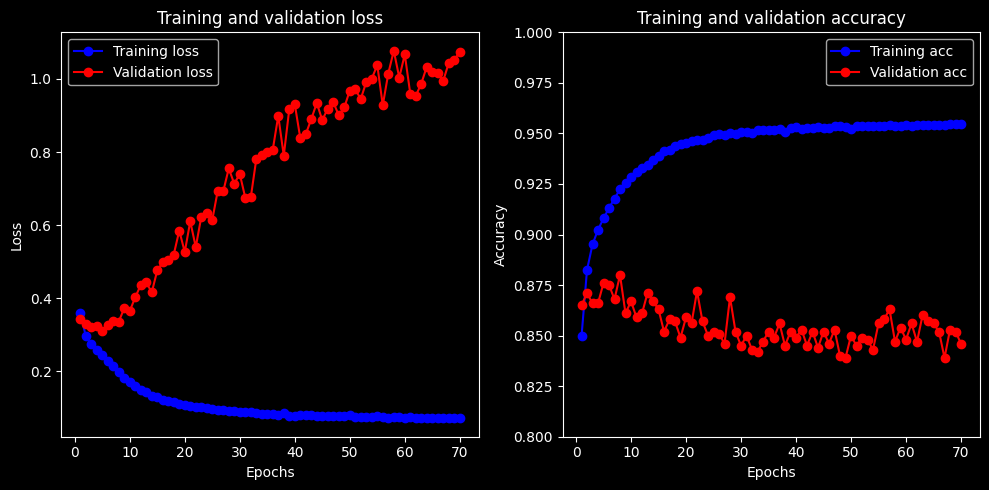

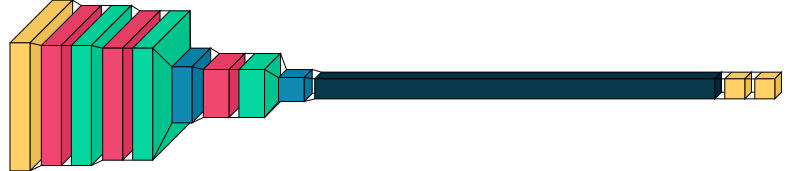

In [14]:
# medium_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(32, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)

x = Dense(8, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=70, model_name="medium_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [15]:
loaded_model = tf.keras.models.load_model(dir + "medium_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 3ms/step - loss: 0.3362 - accuracy: 0.8800


[0.3361859619617462, 0.8799999952316284]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0   

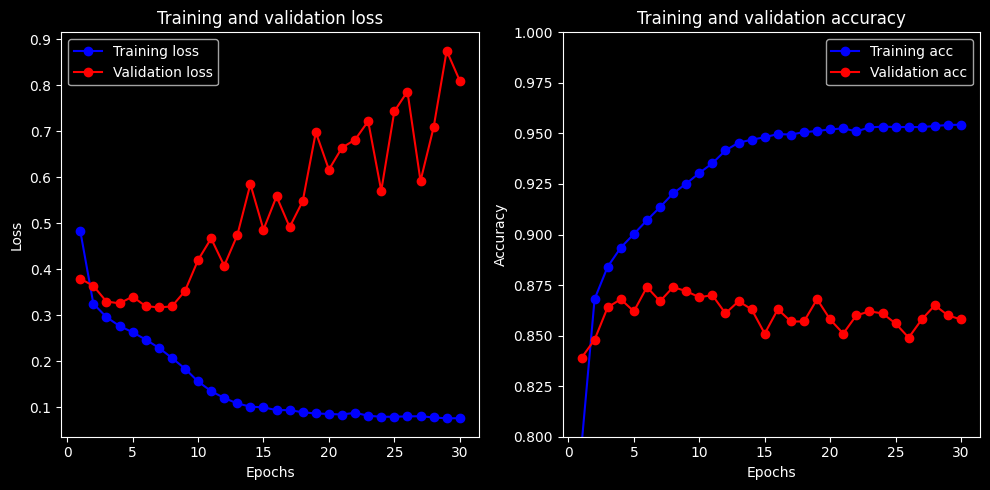

In [16]:
# big_model.h5

from keras.callbacks import ReduceLROnPlateau

# Definir un callback para reducir el learning rate si la función de pérdida se estanca
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0000001)

import time
from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(0.01)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(2048, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)
x = Dense(16, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=30, model_name="big_model.h5", callbacks=[reduce_lr])

import visualkeras
visualkeras.layered_view(model)
time.sleep(60)  

In [17]:
loaded_model = tf.keras.models.load_model(dir + "big_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 11ms/step - loss: 0.3196 - accuracy: 0.8740


[0.31957584619522095, 0.8740000128746033]